In [1]:
import scipy 
import numpy as np
import sympy as sym
import math

from scipy import fabs
from numpy import pi
from scipy import special
import scipy.integrate as integrate
import cmath

import scipy.special as s
import matplotlib.pyplot as plt

import os

import mpmath
from mpmath import *

In [54]:
#mp.dps = 80
from mpmath import mp, fp

# Definindo a precisão da aritmética de ponto flutuante
fp.prec = 30 # Número de bits significativos em ponto flutuante

# Definindo a precisão decimal
mp.dps = 30  # Número de dígitos decimais

In [55]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
import torch
from torchquad import Simpson, set_up_backend, Boole, MonteCarlo, VEGAS, Trapezoid
import inspect
import torch.nn as nn

# Parametros Comuns 

## Constantes

In [5]:
lamb =1064*10**(-9)
#lamb = 9.58*10**(-6)
k = (2 * pi)/lamb
L = 400*10**(-6)
Q = 0.8*k
M = (1.57 - 0.038j)
mi = 1
#alpha = 10
eta_r = 1/M

In [6]:
mi

1

In [7]:
#arrumar eta_r

## Número de Onda

In [8]:
def k_rho(k, alpha):
    return (k*sin(alpha))

def k_z(k, alpha):
    return (k*cos(alpha))

def Z0(k, alpha, x_0, y_0):
    rho_0 = (x_0**2 + y_0**2)**(1/2)
    return (rho_0 * k_rho(k, alpha))

## Funções Especiais e Comuns

In [9]:
#spherical bessel function 1 type 
# j_n = spherical_jn(n, z, derivative = bool) = j_n
def js_n(n):
    return s.spherical_jn(n, x, False)

def js_nz(n, z):
    
    if(n<0):
        return 0
    else:
        return np.where(not isinstance(z, complex) and z<0, (-1)**n*s.spherical_jn(n, -z, False), s.spherical_jn(n, z, False))
        #return s.spherical_jn(n, z, False)
        
def j0_nz(n, z):
    return s.jv(n, z, out=None)

#spherical bessel function 2 type
#y_n = spherical_jn(n, z, derivative = bool)
def ys_n(n):
    return s.spherical_yn(n, x, False)

#Ricatti Bessel 1type given by = x*(j_n(x))
def psiBessel(n, x):
    a = x*(s.spherical_jn(n, x, False))
    return a

#Ricatti Bessel 1type derivative
derivativePsiBesseln = (lambda n, x: ((1 + n)*s.spherical_jn(n, x, False) - (x*s.spherical_jn((n + 1), x, False))))

#Spherical Hankel H2 function 
def sphericalHankel_n(n, x):
    js_n = s.spherical_jn(n, x, False)
    ys_n = s.spherical_yn(n, x, False)
    return js_n - (ys_n*1j)

#Ricatti Bessel 2 type 
def RiccatiBessel_2Type(n, x):
    return x*(sphericalHankel_n(n, x))

#spherical hankel H2 derivative
def derivativeSphericalHankel_n(n, x):
    return (1+n)*sphericalHankel_n(n, x) - x*sphericalHankel_n((n+1), x)

In [10]:
def Eta_r(m, ur):
    epsilon = (m**2) / ur
    divUrEpsilon = ur/epsilon 
    return divUrEpsilon ** (1/2)  

In [11]:
def epsilonR2(m, ur):
    epsilon = (m**2) / ur
    return - epsilon.imag

## Parametros de Integração

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_up_backend("torch", data_type="float64")

num_gpus = torch.cuda.device_count()

torch.set_printoptions(precision=20)

dimension = 1

simp = Simpson()
integration_domain = [[0, L]] * dimension
Qs = np.arange(-75, 76)
points = 130
#Z_vet = torch.linspace(0.00001, L, 100)

## Constantes Auxiliares 

In [13]:
'''
def Z0(k_rho, rho_0):
    return k_rho*rho_0

def k_z(lamb, alpha):
    return k*np.cos(alpha)

def k_rho(lamb, alpha):
    return k*np.sin(alpha)
'''

def epsilon_r(M):
    epsilonLine_r = (M**2).real
    epsilon2Line_r = -(M**2).imag
    return epsilonLine_r + epsilon2Line_r

def kzq(q, Q):
    return (0.8*k) + ((2 *np.pi * q)/L)

## Funções Especiais de Legendre 

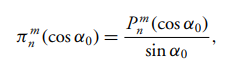

In [14]:
def pi_mn(m, n, x):
    
    cosAlpha = cos(x)
    sinAlpha = sin(x)
    
    num = mpmath.legenp(n, m, cosAlpha)

    #num =  scipy.special.lpmn(m, n, cosAlpha)[0][m][n]
    
    #print('num: ', num, 'sin: ', sinAlpha, 'resul: ',  num/sinAlpha)
    
    return num/sinAlpha

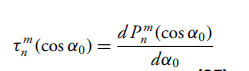


In [15]:
def tau_mn(m, n, x):
    
    #x = cos de alpha 

    pmn = legenp(n, m, x)
    pmn1 =  legenp(n+1, m, x)

    fristTerm = -(n + 1) * x * pmn
    secondTerm = (n - m + 1) * pmn1

    num = fristTerm + secondTerm
    
    
    if x == 1:
        den = sqrt(1 - 0.999999999)
    else:
        den = sqrt(1 - (x**2))
    
    #den = cmath.sqrt((1 - (x**2)))
    
    return num/den

In [16]:
(scipy.special.lpmn(1, 1, cos(pi/360))[0][1][1])

-0.008726535498373064

In [17]:
pi_mn(1, 1, np.pi/360)

mpf('-1.0000000000000000000000000000000000000000000000053776')

In [18]:
pi_mn(1, 1, pi/360)

mpf('-1.0000000000000000000000000000000000000000000000007564')

In [19]:
tau_mn(1, 1, np.cos(np.pi/360))

mpf('-0.99996192306399611737808237715400815166747489794542662')

## $F_z(z)

In [20]:
def Fz(z):
    z_tensor = torch.as_tensor(z)
    L_tensor = torch.as_tensor(L)

    condition = (z_tensor >= L_tensor / 12) & (z_tensor <= 11 * L_tensor / 12)
    expoente = -5 * ((z_tensor - (0.5 * L_tensor)) ** 2 * 1 / L_tensor ** 2)

    value = torch.where(condition,
                        torch.exp(expoente) * torch.cos(6 * torch.pi * z_tensor / L_tensor),
                        torch.tensor(0))
    return value

In [21]:
'''
F_values = []
for z in Z_vet: 
    F_values.append(torch.abs(Fz(z))**2)

plt.plot(Z_vet.cpu(), torch.as_tensor(F_values).cpu(), 'r')

plt.xlabel(r'$z$')
plt.grid()
plt.show()
'''

"\nF_values = []\nfor z in Z_vet: \n    F_values.append(torch.abs(Fz(z))**2)\n\nplt.plot(Z_vet.cpu(), torch.as_tensor(F_values).cpu(), 'r')\n\nplt.xlabel(r'$z$')\nplt.grid()\nplt.show()\n"

# Coeficiente $A_q$

In [22]:
def Aq(q, L):

    frac = 1 / L 
    integration_domain = [[0, L]]
    
    integrand = lambda z: (Fz(z) * 
                           torch.exp(torch.as_tensor(1j * z * (2 * torch.pi * q) / L)))
    
    real_integrand = lambda x: integrand(x).real
    complex_integrand = lambda x: integrand(x).imag
    
    real_integral = simp.integrate((real_integrand), dim=1, N=301, integration_domain=integration_domain).item()
    complex_integral = simp.integrate((complex_integrand), dim=1, N=301, integration_domain=integration_domain).item()
    
    if complex_integral == 0.0:
        integral_val = real_integral * frac
    
    else:
        integral_val = (real_integral + 1j*complex_integral) * frac
        
    return integral_val

In [23]:
#Aq = torch.tensor([torch.log(torch.abs(torch.as_tensor(solveAq(zg, q, L)))) for q in Qs])
aq_normal = []
#aq_normal = [np.log(np.abs(solve(q, L))) for q in Qs]
for q in Qs:
    aq_normal.append(np.log(np.abs(Aq(q, L))))
    #aq_normal.append(solve(q, L))
#para fazer log -> dar return integral 
#integral = torch.log(torch.abs(torch.as_tensor(integral)))
#print(type(Aq))
#print(type(np.array(Aq.tolist())))

D:\Anaconda\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


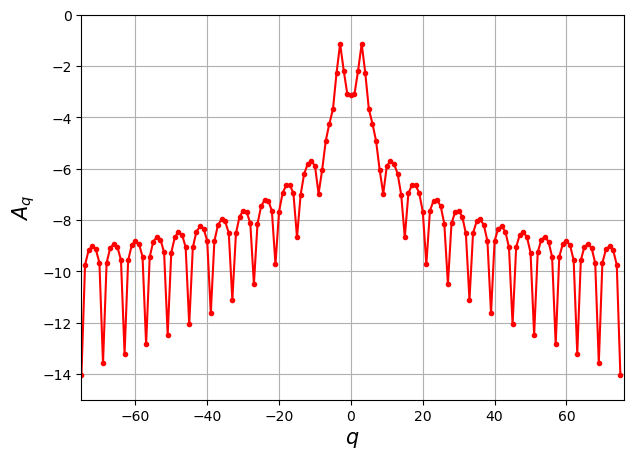

In [24]:
plt.figure(figsize=[7,5])
plt.plot(Qs, aq_normal, 'r.-')
plt.ylim(-15, 0)
plt.xlim(-75,76)
plt.ylabel(r'$A_q$', fontsize=15)
plt.xlabel(r'$q$', fontsize=15)
plt.grid()

# Fator de forma $g_n$

## $g_{nTE}$

In [25]:
def g_mnTE(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0):
    
    cosAxicon =  cos(alpha1)
    sinAxicon =  sin(alpha1)
    
    alpha = alpha1
    constZ0 = Z0(k, alpha1, x_0, y_0)

    a1 =  a1 = 1j*(-1/2)*(1j**(m+1))*(-1)**((m - abs(m)) * 1/2)
    
    b = (fac(n - m))/(fac(n + abs(m)))
    c = exp(1j*k*cosAxicon*z_0)

    d = besselj(m-v-1, k*sinAxicon*rho_0)*exp(-1j*(m-v-1)*phi_0)
    e = (tau_mn(m,n, cosAxicon)/cosAxicon) + (m*pi_mn(m, n, alpha))

    f = besselj(m-v+1, k*sinAxicon*rho_0)*exp(-1j*(m-v+1)*phi_0)
    g = (-tau_mn(m, n, cosAxicon)/cosAxicon) + (m*pi_mn(m, n, alpha))
    
    result = ((a1*b*c)*((d*e)-(f * g)))
    
    return result

## $g_{nTM}$

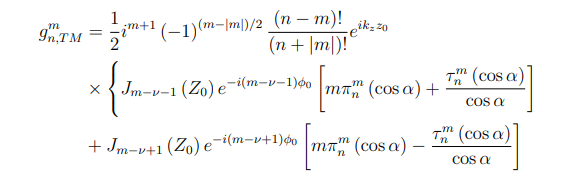

In [26]:
def g_mnTM(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0):
    
    cosAxicon =  cos(alpha1)
    sinAxicon =  sin(alpha1)
    
    alpha = alpha1
    constZ0 = Z0(k, alpha1, x_0, y_0)
    
    args = k*sinAxicon*rho_0 #ok

    a1 = (1/2) * (1j**(m+1)) * (-1)**((m - abs(m)) * (1/2))
    b = (fac(n - m))/(fac(n + abs(m))) 
    
    c = exp(1j*k*cosAxicon*z_0) #ok

    d = (besselj(m - v - 1,  k*sinAxicon*rho_0))*exp(-1j*(m - v - 1)*phi_0)
    
    e = (tau_mn(m, n, cosAxicon)/cosAxicon) + (m*pi_mn(m, n, alpha))

    f = (besselj(m - v + 1,  k*sinAxicon*rho_0))*exp(-1j*(m - v + 1)*phi_0)
    
    g = (-tau_mn(m, n, cosAxicon)/cosAxicon) + (m*pi_mn(m, n, alpha)) 
    
    result =  (a1*b*c)*((d*e) + f*g)
    
    return result

In [27]:
#g_mnTM(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
#D_mn(-1, 1, M, 0.1, 0, np.pi/360, 0.1*spoti, 0, 0, 0, 0)
#I_z(M, x, epislon, v, alpha, rho_0, z_0):
axicon = np.pi/360
spoti = ((405/100)/(k * math.sin(axicon)))
g_mnTM(-1, 1, 0,  pi/360, lamb, 0.1*spoti,0, 0, 0, 0)

mpc(real='0.47970610884383683596972074128499491904836378209725791', imag='0.0')

In [28]:
g_mnTE(-1, 1, 0,  pi/360, lamb, 0.1*spoti,0, 0, 0, 0)

mpc(real='0.0', imag='0.47970610884383683596972074128499491904836378209725657')

# Coeficientes 

## $c_s$ e $d_s$

In [30]:
#coefficient C_n
def cs_n(M, mi, n, x):
    dem = (M*mi*((RiccatiBessel_2Type(n, x)*derivativePsiBesseln(n, x)) - derivativeSphericalHankel_n(n, x)*psiBessel(n, x)))
    num = (mi*RiccatiBessel_2Type(n, x)*derivativePsiBesseln(n, x*M) - M*derivativeSphericalHankel_n(n, x)*psiBessel(n, x*M))
    return dem/num

#coefficient D_n
def ds_n(M, mi, n, x):
    dem = (M*M)*(RiccatiBessel_2Type(n, x)*derivativePsiBesseln(n, x) - derivativeSphericalHankel_n(n, x)*psiBessel(n, x))
    num = (M*RiccatiBessel_2Type(n, x)*derivativePsiBesseln(n, M*x)) - (mi*derivativeSphericalHankel_n(n, x)*psiBessel(n, M*x))
    return dem/num

## $R_n$

In [31]:
#coefficient r_n
def r_n(m, n, x):
    psiConj = conj(psiBessel(n, m*x))
    dem = (m*psiBessel(n+1, m*x)*psiConj)
    num = m*m
    return (dem.imag)/(num.imag)

## $S_n$

In [32]:
def S_n(M, n, x):
    
    m = M
    a = ((1j)/(2*((m**2).imag)))
    b = (m*((abs(psiBessel(n, m*x))**2)))
    c = (conj(m)) * (abs(psiBessel(n+1, m*x)))**2
    d = (m +((((2*(n + 1)*((m*m).real)/m)))))*r_n(m, n, x)
    e = (2*n + 1)*(conj(m)*r_n(m, n+1, x))

    return -a*(x*(b+c) - d + e)

## $A_n$

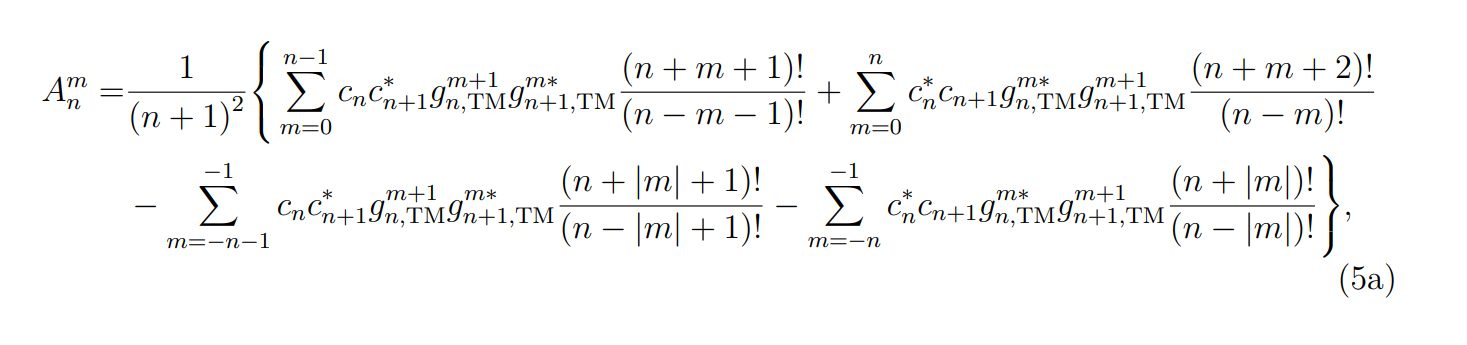

In [33]:
def A_mn(n, M, x, v,alpha1, rho_0, phi_0, x_0, y_0, z_0):
    
    soma1 = []
    soma2 = []
    soma3 = []
    soma4 = []
    total1 = 0
    total2= 0
    total3=0
    total4=0
    
    a = 1/((n + 1)**2)
    
    for m in range(0, (n - 1 + 1)):
        
        c1 = cs_n(M, mi, n, x)
        c1conj = conj(cs_n(M, mi, n+1, x))
        c1_gTM = g_mnTM(m+1, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c1_gTM_conj = conj(g_mnTM(m, n+1, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        c1_fact_num = fac(n + m + 1)
        c1_fact_dem = fac(n - m - 1)
        
        soma1 = c1*c1conj*c1_gTM*c1_gTM_conj*(c1_fact_num/c1_fact_dem)
        total1 += soma1
    
    for m in range(0, n + 1):
        
        c2_conj = conj(cs_n(M, mi, n, x))
        c2 = cs_n(M, mi, n+1, x)
        c2_gTM_conj = conj(g_mnTM(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        c2_gTM = g_mnTM(m+1, n+1, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c2_fact_num = fac(n + m + 2)
        c2_fact_dem = fac(n - m)
        
        soma2 = c2_conj*c2*c2_gTM_conj*c2_gTM*(c2_fact_num/c2_fact_dem)
        total2 += soma2
        
    for m in range(-n-1, -1 + 1):
        c3 = cs_n(M, mi, n, x)
        c3_conj = conj(cs_n(M, mi, n+1, x))
        c3_gTM = g_mnTM(m+1, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c3_gTM_conj = conj(g_mnTM(m, n+1, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        c3_fact_num = fac(n + fabs(m) + 1)
        c3_fact_dem = fac(n - fabs(m) + 1)
        
        soma3 = c3*c3_conj*c3_gTM*c3_gTM_conj*(c3_fact_num/c3_fact_dem)
        total3 += soma3
        
    for m in range(-n, -1 +1 ):
        c4_conj = conj(cs_n(M, mi, n, x))
        c4 = cs_n(M, mi, n+1, x)
        c4_gTM_conj = conj(g_mnTM(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        c4_gTM =g_mnTM(m+1, n+1, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c4_fact_num = fac(n + fabs(m))
        c4_fact_dem = fac(n - fabs(m))
        
        soma4 = c4_conj*c4*c4_gTM_conj*c4_gTM*(c4_fact_num/c4_fact_dem)
        total4 += soma4
    
    resul = a*(total1 + total2 - total3 - total4)
    
    return resul

## $B_n$

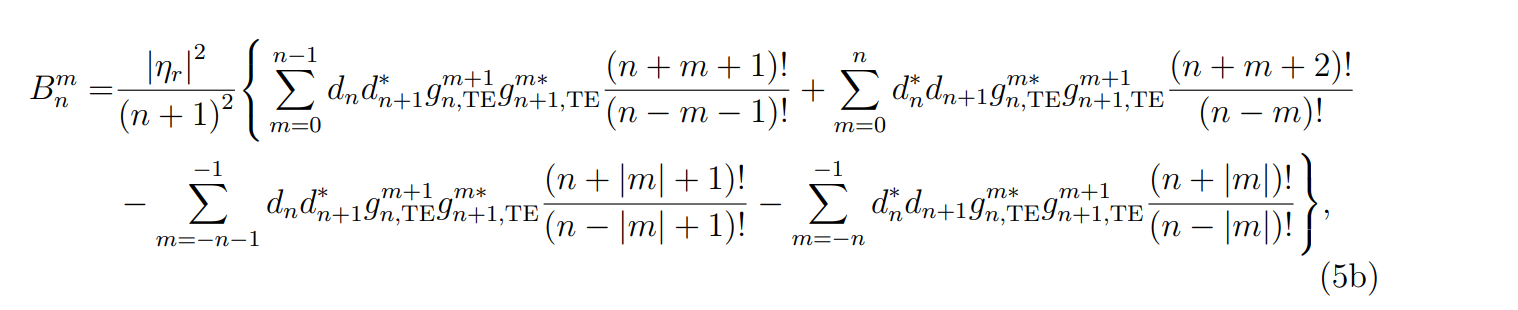

In [34]:
def B_mn(n, M, x, v,alpha1, rho_0, phi_0, x_0, y_0, z_0):
    
    
    soma1 = []
    soma2 = []
    soma3 = []
    soma4 = []
    total1 = 0
    total2= 0
    total3= 0
    total4= 0
    
    eta_r = Eta_r(M, 1)
    const = (abs(eta_r)**2)/(n + 1)**2
    
    for m in range(0, (n - 1 + 1)):
        
        c1 = ds_n(M, mi, n, x)
        c1conj = conj(ds_n(M, mi, n+1, x))
        c1_gTE = g_mnTE(m+1, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c1_gTE_conj = conj(g_mnTE(m, n+1, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        c1_fact_num = fac((n + m + 1))
        c1_fact_dem = fac((n - m - 1))
        
        soma1 = c1*c1conj*c1_gTE*c1_gTE_conj*(c1_fact_num/c1_fact_dem)
        total1 += soma1
    
    for m in range(0, n+1):
        
        c2_conj = conj(ds_n(M, mi, n, x))
        c2 = ds_n(M, mi, n+1, x)
        c2_gTE_conj = conj(g_mnTE(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        c2_gTE =g_mnTE(m+1, n+1, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c2_fact_num = fac(n + m + 2)
        c2_fact_dem = fac(n - m)
        
        soma2 = c2_conj*c2*c2_gTE_conj*c2_gTE*(c2_fact_num/c2_fact_dem)
        total2 += soma2
        
    for m in range(-n-1, -1+1):
        
        c3 = ds_n(M, mi, n, x)
        c3_conj = conj(ds_n(M, mi, n+1, x))
        c3_gTE = g_mnTE(m+1, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c3_gTE_conj = conj(g_mnTE(m, n+1, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        c3_fact_num = fac(n + abs(m) + 1)
        c3_fact_dem = fac(n - abs(m) + 1)
        
        soma3 = c3*c3_conj*c3_gTE*c3_gTE_conj*(c3_fact_num/c3_fact_dem)
        total3 += soma3
        
    for m in range(-n, -1 + 1):
        
        c4_conj = conj(ds_n(M, mi, n, x))
        c4 = ds_n(M, mi, n+1, x)
        c4_gTE_conj = conj(g_mnTE(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        c4_gTE = g_mnTE(m+1, n+1, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c4_fact_num = fac(n + abs(m))
        c4_fact_dem = fac(n - abs(m))
        
        soma4 = c4_conj*c4*c4_gTE_conj*c4_gTE*(c4_fact_num/c4_fact_dem)
        total4 += soma4
    
    resul = const*(total1 + total2 - total3 - total4)
    
    return resul
    

## $C_n$

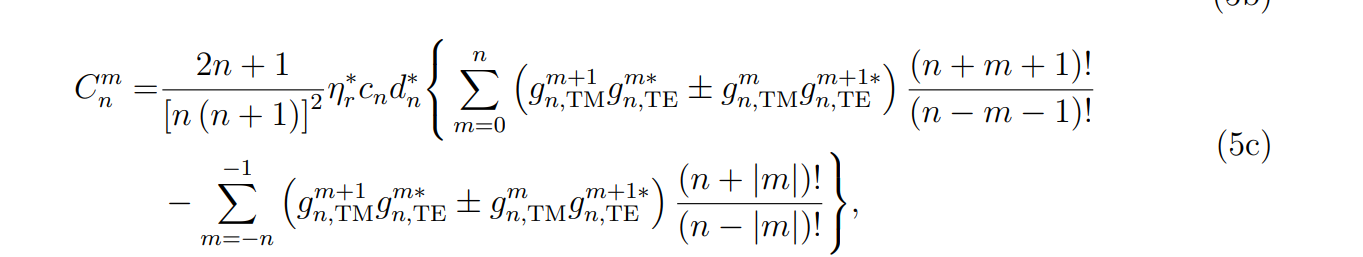

In [35]:
def C_mnx(n, M, x, v,alpha1, rho_0, phi_0, x_0, y_0, z_0):
    
    soma1 = []
    soma2 = []
    total1 = 0
    total2 = 0
    
    eta_r = Eta_r(M, 1)
    frac = ((2*n) + 1)/((n**2)*((n+1)**2))
    conj_eta = conj(eta_r)
    cn = cs_n(M, mi, n, x)
    dn = conj(ds_n(M, mi, n, x))
    
    for m in range(0, (n)):
        
        c1_gTM = g_mnTM(m+1, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c1_conj_gTE = conj(g_mnTE(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        c1_gn_TM2 =  g_mnTM(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c1_conj_gTE2 = conj(g_mnTE(m+1, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        
        c1_fact_num = fac(n + m + 1)
        c1_fact_dem = fac(n - m - 1)
        
        soma1 = (c1_gTM*c1_conj_gTE + c1_gn_TM2*c1_conj_gTE2)*(c1_fact_num/c1_fact_dem )
        total1 += soma1
    
    for m in range(-n, -1 + 1):
        
        c2_gTM = g_mnTM(m+1, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c2_conj_gTE = conj(g_mnTE(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        c2_gn_TM2 =  g_mnTM(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c2_conj_gTE2 = conj(g_mnTE(m+1, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        
        c2_fact_num = fac(n + abs(m))
        c2_fact_dem = fac(n - abs(m))
        
        soma2 = (c2_gTM*c2_conj_gTE + c2_gn_TM2*c2_conj_gTE2)*(c2_fact_num/c2_fact_dem )
        total2 += soma2
        
    resul = frac*conj_eta*cn*dn*(total1 - total2)
    
    return resul

In [36]:
def C_mny(n, M, x, v,alpha1, rho_0, phi_0, x_0, y_0, z_0):
    
    soma1 = []
    soma2 = []
    total1 = 0
    total2= 0
    
    eta_r = Eta_r(M, 1)
    frac = (2*n + 1)/((n*(n+1))**2)
    conj_eta = conj(eta_r)
    cn = cs_n(M, mi, n, x)
    dn = conj(ds_n(M, mi, n, x))
    
    for m in range(0, (n - 1 + 1)):
        
        c1_gTM = g_mnTM(m+1, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c1_conj_gTE = np.conjugate(g_mnTE(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        c1_gn_TM2 =  g_mnTM(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c1_conj_gTE2 = np.conjugate(g_mnTE(m+1, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        
        c1_fact_num = special.factorial(n + m + 1)
        c1_fact_dem = special.factorial(n - m - 1)
        
        soma1 = (c1_gTM*c1_conj_gTE - c1_gn_TM2*c1_conj_gTE2)*(c1_fact_num/c1_fact_dem )
        total1 += soma1
    
    for m in range(-n, -1 + 1):
        
        c2_gTM = g_mnTM(m+1, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c2_conj_gTE = np.conjugate(g_mnTE(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        c2_gn_TM2 =  g_mnTM(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
        c2_conj_gTE2 = np.conjugate(g_mnTE(m+1, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
        
        c2_fact_num = special.factorial(n + abs(m))
        c2_fact_dem = special.factorial(n - abs(m))
        
        soma2 = (c2_gTM*c2_conj_gTE - c2_gn_TM2*c2_conj_gTE2)*(c2_fact_num/c2_fact_dem )
        total2 += soma2
        
    resul = frac*conj_eta*cn*dn*(total1 - total2)
    
    return resul

## $D_n$

In [37]:
def D_mn(m, n, M, x, v,alpha, rho_0, phi_0, x_0, y_0, z_0):
    
    alpha1 = alpha
    a1 = 1/(n + 1)**2
    
    bcsn = cs_n(M, mi, n, x)
    bc = np.conjugate(bcsn)
    
    b = bc*cs_n(M, mi, n+1, x) 
    
    cgs = g_mnTM(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
    c = np.conjugate(cgs)
    
    d = g_mnTM(m, n + 1, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
    
    e_num = special.factorial(n + np.abs(m) + 1, True)
    e_dem = special.factorial(n - np.abs(m), True)
    e =  e_num/e_dem

    return (a1*b*c*d*e)

## $E_n$

In [38]:
def E_mn(m, n, M, x, v, alpha, rho_0, phi_0, x_0, y_0, z_0):
    
    alpha1 = alpha
    eta_r = Eta_r(M, 1)

    a1 = (abs(eta_r)**2) / ((n + 1)**2)
    
    b = np.conjugate(ds_n(M, mi, n, x))*ds_n(M, mi, n+1, x)
    c = np.conjugate(g_mnTE(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
    d = g_mnTE(m, n+1, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
    
    e = special.factorial(n + np.abs(m) + 1, True)/(special.factorial(n - np.abs(m), True))

    return (a1*b*c*d*e)

## $F_n$

In [39]:
def F_mn(m, n, M, x, v,alpha, rho_0, phi_0, x_0, y_0, z_0):
    
    alpha1 = alpha
    eta_r = Eta_r(M, 1)
    a1 = (m*np.conjugate(eta_r)) * ((2*n + 1)/((n*(n + 1))**2))
    
    b = (cs_n(M, mi, n, x))*(np.conjugate(ds_n(M, mi, n, x)))
    
    c = g_mnTM(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0)
    d = np.conjugate(g_mnTE(m, n, v, alpha1, lamb, rho_0, phi_0, x_0, y_0, z_0))
    
    e = special.factorial(n + np.abs(m), True)/special.factorial(n - np.abs(m), True)

    return (a1 * b * c * d * e)

In [40]:
#F_mn(m, n, M, x, v, alpha, rho_0, phi_0, x_0, y_0, z_0)
ax = pi/20
x_tam = 1
spoti = ((405/100)/(k *sin(ax)))
0.1*spoti

mpf('0.00000043841392662110470578559862064717025817827416082124597')

In [41]:
D_mn(1, 2, M, x_tam, 0, ax, 0.1*spoti, 0, 0, 0, 0)
#0.09359 + 0.0026154 I

mpc(real='0.074702202379655309295588385945661698924784188584218957', imag='0.0030757211452954838650063444268017527458969274855744252')

In [42]:
E_mn(1, 2, M, x_tam, 0, ax, 0.1*spoti, 0, 0, 0, 0)

mpc(real='0.076680119260451566733491512493490617839495024253070832', imag='0.0022526921392434412818205921143069698119715360495910137')

In [43]:
F_mn(1, 2, M, x_tam, 0, ax, 0.1*spoti, 0, 0, 0, 0)

mpc(real='0.0001677712875979636268076883554301402756456127295596119', imag='0.041475054171699672464134975910942327024370401432668255')

In [44]:
# A_mn(m, n, M, x, v,alpha1, rho_0, phi_0, x_0, y_0, z_0):
A_mn( 2, M, x_tam, 0, ax, 0.1*spoti, 0, 0, 0, 0)

mpc(real='-1.1600541276441820736858899477667649520598031328990747e-54', imag='-0.045111813543019045879476424048884474121813278201130174')

In [45]:
B_mn(2, M, x_tam, 0,ax, 0.1*spoti, 0, 0, 0, 0)

mpc(real='-1.1758843531601653362443685000556109515107224447791283e-55', imag='-0.015522438012738532527212473845789745363470622786164954')

In [46]:
C_mny(2, M, x_tam, 0, ax, 0.1*spoti, 0, 0, 0, 0)

mpc(real='-4.2202635726195505328929628643289041926626830023712584e-53', imag='1.7071443732177012163831809505380526281947738230955338e-55')

In [56]:
#C_mny(n, M, x, v, alpha1, rho_0, phi_0, x_0, y_0, z_0):
C_mnx(2, M, x_tam, 0, ax, 0.1*spoti, 0, 0, 0, 0)

mpc(real='-0.0165047316157929985991127161475975', imag='0.0000667635071235142727680104159065217')

# Fator de Assimetria 

In [48]:
ceillingX = lambda x : math.ceil(x + (4.05 * (x ** (1/3))) + 2)

## $I_z$

In [49]:
def I_z(M, x, epislon, v, alpha, rho_0, z_0):
    
    iz_total = 0
    pytorch_soma = []
    a = x/k
    
    eta_r = Eta_r(M, 1)

    #mudar dps 
    #rho_0 = 0
    phi_0 = 0
    
    #const = (16 * np.pi * (a**3)) / ( (abs(M)**2) * x**3)
    const = (6* epislon) / ((abs(M)**2) * x**3)
    
    soma = []
    total = 0
    nMax = ceillingX(x)
    x_0 = 0
    y_0 = 0
    

    #O m é limitado de -n até +n mas, para o caso on-axis, basta de -1 a 1
    for n in range(1, nMax+1):
        for m in range(-n, n+1):

            a1 = D_mn(m, n, M, x, v, alpha, rho_0, phi_0, x_0, y_0, z_0)
            b = np.conjugate(S_n(M, n, x)) + (( (n + 1)/M) * r_n(M, n+1, x))

            c = E_mn(m, n, M, x, v, alpha, rho_0, phi_0, x_0, y_0, z_0)

            d = (-S_n(M, n, x) + (((n + 1)/M)*r_n(M, n, x)) )

            e = (1j*F_mn(m, n, M, x, v, alpha, rho_0, phi_0, x_0, y_0, z_0)) 
            sn = S_n(M, n, x)

            soma = (a1*(b)) + (c*(d)) + (e*sn)
            #soma = np.nan_to_num((a*b) + c*d + e)

            #pytorch_soma.append(iz_val)
            #if (np.isnan(iz_val)):
                #z_val = 0
            total += soma
            #print("soma:", soma)
            #print(iz_val)
            
    #iz_total = torch.sum(torch.as_tensor(pytorch_soma))
    #print((total.imag)*const)
    
    #return (iz_total.imag)*const
    #print("soma:", soma)
    return const * total.imag

## $I_x$ e $I_y$

In [50]:
def I_x(M, x, epislon, v, alpha, rho_0, z_0):
    
    phi_0 = 0
    a = x/k
    x_0 = 0
    y_0 = 0
    
    soma = []
    total = 0
    
    #const = (8 * pi * (a**3)) / ((abs(M)**2)*x**3)
    const = (3 * epislon) / ((abs(M)**2) * (x**3))
    
    ceillingX = (lambda x: math.ceil(x + 4.05*x**(1/3)+2))
    nMax = ceillingX(x)
    
    for n in range(1, nMax+1):
        
        a1 =  A_mn(n, M, x, v, alpha, rho_0, phi_0, x_0, y_0, z_0)
        s1 = np.conjugate(S_n(M, n, x))
        f1 = (n+1)/M
        r1 = r_n(M, n+1, x)
        
        b = B_mn(n, M, x, v, alpha, rho_0, phi_0, x_0, y_0, z_0)
        s2 = -S_n(M, n, x)
        f2 = (n+1)/M 
        r2 = r_n(M, n, x)
        
        c = 1j*C_mnx(n, M, x, v, alpha, rho_0, phi_0, x_0, y_0, z_0)
        s3 = S_n(M, n, x)
        
        soma = a1*(s1 + (f1*r1)) + b*(s2 + (f2*r2)) + (c*s3)
        total+= soma
        
    return (const * (total.imag))

In [51]:
def I_y(M, x, epislon, v, alpha, rho_0, z_0):
    
    phi_0 = 0
    x_0 = 0
    y_0 = 0
    a = x/k
    
    soma = []
    total = 0
    
    #const = (8*pi*(a**3)) / ((abs(M)**2)*x**3)
    const = (3 * epislon) / ((abs(M)**2) * (x**3))
    
    ceillingX = (lambda x: math.ceil(x + 4.05*x**(1/3)+2))
    nMax = ceillingX(x)
    
    for n in range(1, nMax+1):
        
        a1 =  A_mn(n, M, x, v, alpha, rho_0, phi_0, x_0, y_0, z_0)
        s1 = np.conjugate(S_n(M, n, x))
        f1 = (n+1)/M
        r1 = r_n(M, n+1, x)
        
        b = B_mn(n, M, x, v, alpha, rho_0, phi_0, x_0, y_0, z_0)
        s2 = -S_n(M, n, x)
        f2 = (n+1)/M 
        r2 = r_n(M, n, x)
        
        c = 1j*C_mny(n, M, x, v, alpha, rho_0, phi_0, x_0, y_0, z_0)
        s3 = S_n(M, n, x)
        
        soma = a1*(s1 + (f1*r1)) + b*(s2 + (f2*r2)) + (c*s3)
        total+= soma
        
    return (const*(total.real))

# Comparação 

In [52]:
#I_z(M, x, epislon, v, alpha, rho_0, z_0):
ax = pi/20
x_tam1 = 0.1
x_tam2 = 0.5
x_tam3 = 1
x_tam4 = 3
spoti = ((405/100)/(k *sin(ax)))
rho0 = (4)*spoti
print('Iz: ', I_z(M, x_tam1, epsilonR2(M, 1),  0, ax, rho0 , 0), ', x: ', x_tam1)
print('Ix: ', I_x(M, x_tam1, epsilonR2(M, 1),  0, ax, rho0 , 0))
print('Iy: ', I_y(M, x_tam1, epsilonR2(M, 1),  0, ax, rho0 , 0))

Iz:  -0.00000013967398444197283492891229861653454161681967686299 , x:  0.1
Ix:  0.00000072739195196714434697684395277460133055513774672211
Iy:  0.000000011458903382438492022624557761691895012659481504777


In [ ]:
print('Iz: ', I_z(M, x_tam2, epsilonR2(M, 1),  0, ax, rho0 , 0), ', x: ', x_tam2)
print('Ix: ', I_x(M, x_tam2, epsilonR2(M, 1),  0, ax, rho0 , 0))
print('Iy: ', I_y(M, x_tam2, epsilonR2(M, 1),  0, ax, rho0 , 0))

In [ ]:
print('Iz: ', I_z(M, x_tam3, epsilonR2(M, 1),  0, ax, rho0 , 0), ', x: ', x_tam3)
print('Ix: ', I_x(M, x_tam3, epsilonR2(M, 1),  0, ax, rho0 , 0))
print('Iy: ', I_y(M, x_tam3, epsilonR2(M, 1),  0, ax, rho0 , 0))

In [ ]:
print('Iz: ', I_z(M, x_tam4, epsilonR2(M, 1),  0, ax, rho0 , 0), ', x: ', x_tam4)
print('Ix: ', I_x(M, x_tam4, epsilonR2(M, 1),  0, ax, rho0 , 0))
print('Iy: ', I_y(M, x_tam4, epsilonR2(M, 1),  0, ax, rho0 , 0))

In [ ]:
x_vet  = [[ 1/10,  1/10,  1/10,  1/10,  1/10,  1/10],
          [1/5,  1/5,  1/5,  1/5,  1/5,  1/5],
          [1, 1, 1, 1, 1, 1],
          [3, 3, 3, 3, 3, 3]]

In [ ]:
axicons = [10**(-10), np.pi/360, np.pi/180, np.pi/20, np.pi/6, np.pi/3]

In [ ]:
spot = []
for axicon in axicons:
    result = (405/100) / (k * cmath.sin(axicon))
    spot.append(result)

## Para $\rho_0 = 0$

In [ ]:
M

In [ ]:
#I_z(M, x, epislon, v, alpha, z_0):

In [ ]:
i1 = I_z(M, 1/10, epsilonR2(M, 1),  0, 0.1**(-10),0 ,0)
i2 = I_z(M, 1/10, epsilonR2(M, 1),  0, np.pi/360,0, 0)
i3 = I_z(M, 1/10, epsilonR2(M, 1),  0, np.pi/180,0,  0)
i4 = I_z(M, 1/10, epsilonR2(M, 1),  0, np.pi/20,0,  0)
i5 = I_z(M, 1/10, epsilonR2(M, 1),  0, np.pi/6, 0, 0)
i6 = I_z(M, 1/10, epsilonR2(M, 1),  0, np.pi/3, 0,  0)

In [ ]:
i12 = I_z(M, 1/5, epsilonR2(M, 1),  0, 0.1**(-10), 0 ,0)
i22 = I_z(M, 1/5, epsilonR2(M, 1),  0, np.pi/360,0 ,0)
i32 = I_z(M, 1/5, epsilonR2(M, 1),  0, np.pi/180, 0 ,0)
i42 = I_z(M, 1/5, epsilonR2(M, 1),  0, np.pi/20 , 0, 0)
i52 = I_z(M, 1/5, epsilonR2(M, 1),  0, np.pi/6, 0, 0 )
i62 = I_z(M, 1/5, epsilonR2(M, 1),  0, np.pi/3, 0, 0)

In [ ]:
i13 = I_z(M, 1, epsilonR2(M, 1),  0, 0.1**(-10),0,  0)
i23 = I_z(M, 1, epsilonR2(M, 1),  0, np.pi/360, 0, 0)
i33 = I_z(M, 1, epsilonR2(M, 1),  0, np.pi/180,0, 0)
i43 = I_z(M, 1, epsilonR2(M, 1),  0, np.pi/20, 0,0)
i53 = I_z(M, 1, epsilonR2(M, 1),  0, np.pi/6, 0,0)
i63 = I_z(M, 1, epsilonR2(M, 1),  0, np.pi/3, 0,0)

In [ ]:
i14 = I_z(M, 3, epsilonR2(M, 1),  0, 0.1**(-10),0,  0)
i24 = I_z(M, 3, epsilonR2(M, 1),  0, np.pi/360, 0, 0)
i34 = I_z(M, 3, epsilonR2(M, 1),  0, np.pi/180, 0, 0)
i44 = I_z(M, 3, epsilonR2(M, 1),  0, np.pi/20, 0, 0)
i54 = I_z(M, 3, epsilonR2(M, 1),  0, np.pi/6, 0, 0)
i64 = I_z(M, 3, epsilonR2(M, 1),  0, np.pi/3, 0, 0)

In [ ]:
i2

## Para $\rho_0 = spot \cdot \frac{1}{10}$

In [ ]:
#I_z(M, x, epislon, v, alpha, rho_0, z_0):

In [ ]:
axicons = [10**(-10), np.pi/360, np.pi/180, np.pi/20, np.pi/6, np.pi/3]

spot = []
for axicon in axicons:
    result = ((405/100)/(k * math.sin(axicon)))
    spot.append(result)

In [ ]:
Iz_bia_vet0 = [[i1, i2, i3, i4, i5, i6],
             [i12, i22, i32, i42, i52, i62],
             [i13, i23, i33, i43, i53, i63],
             [i14, i24, i34, i44, i54, i64]]

Iz_bia_vet = [iz_01_x01 +iz_01_x05 +iz_01_x1 +iz_01_x3 +iz_02_x01 +iz_02_x05 +iz_02_x1 +iz_02_x3 +iz_05_x01 +iz_05_x05 +iz_05_x1 +iz_05_x3 +iz_2_x01 +iz_2_x05 + iz_2_x1 + iz_2_x3 +iz_4_x01 + iz_4_x05 +iz_4_x1 +iz_4_x3]


In [ ]:
iz_02_x05

In [ ]:
df = pd.DataFrame({"x": (5*(x_vet[0] + x_vet[1] + x_vet[2] + x_vet[3])),
                   "rho (spot)": (20*spot), 
                   "Axicon (rad)": (20*axicons),
                   "Valor Iz - bia": Iz_bia_vet[0]
                   #"Valor Jz - Leo": (3*[2, 4, 5, 5, 6, 6])
                  })
table = pd.pivot_table(df, values=['Valor Iz - bia'], index=['x', 'rho (spot)','Axicon (rad)'])
table

In [ ]:
M

In [ ]:
spoti

In [ ]:
for axicon, spoti in zip(axicons, spot):
    print(axicon, spoti)

## Para $\rho_0 = spot \cdot \frac{1}{5}$

In [ ]:
data12 = {
    'Axicon (rad)': axicons,
    'x': x_vet[1],
    'Valor Iz - bia': [ I_z(M, x_vet[1][0], epsilonR2(M, 1), 0, axicons[0], 0.2*spot[0], 0),
                       I_z(M, x_vet[1][0], epsilonR2(M, 1), 0, axicons[1], 0.2*spot[1], 0), 
                       I_z(M, x_vet[1][0], epsilonR2(M, 1), 0, axicons[2], 0.2*spot[2], 0), 
                       I_z(M, x_vet[1][0], epsilonR2(M, 1), 0, axicons[3], 0.2*spot[3], 0),
                       I_z(M, x_vet[1][0], epsilonR2(M, 1), 0, axicons[4], 0.2*spot[4], 0),
                        I_z(M, x_vet[1][0], epsilonR2(M, 1), 0, axicons[5], 0.2*spot[5], 0)
                      ],
    'Valor Jz - Leo': [-3.88627*10**-6, -3.8863*10**-6 , -3.88638*10**-6, 
                       -3.89544*10**-6, -3.98969*10**-6 , -4.35183*10**-6]
    }
pd.set_option('display.float_format','{:.8e}'.format)
tabela12 = pd.DataFrame(data12)
tabela12

## Para $\rho_0 = spot \cdot \frac{1}{2}$

## Para $\rho_0 = spot \cdot 2 $

## Para $\rho_0 = spot \cdot 4$

In [ ]:
part_vol = (4/3)*np.pi*(0.1/k)**3
raio = (0.1/k)**3
fator_epsilon = -(M**2).imag / 2
fator_epsilon

In [ ]:
#I_z(M, x, v, alpha, z_0)
Iz3 =I_z(1.57 - 0.038j, 1/10, eps,  0, np.pi/3, 0, 0)
Iz3

In [ ]:
#I_z(M, x, v, alpha, z_0)
Iz3 =I_z(1.57 - 0.038j, 1/10, eps, 0, 0.001, 0)
Iz3

In [ ]:
j_transformado = (Iz3 * (-(M**2).imag) ) / (part_vol * 2)
j_transformado

In [53]:
M1 = (1.57 - 0.38j)
M2 = 1.57 - 0.01*1j
M3 = 1.57 - 1j

In [58]:
zval = np.linspace(0, 400*10**(-6), 100)
xval = np.linspace(0.1, 20, 50)

eps = epsilonR2(M, 1)
eps1 = epsilonR2(M1, 1)
eps2 = epsilonR2(M2, 1)
eps3 = epsilonR2(M3, 1)

cnt = 0
jn1_gauss_blue = []
jn2_gauss_red = []
jn3_gauss_green = []
jn4_gauss_green = []

n1 = []
n2 = []
n3 = []
n4 = []


#gauss bean M = 1.57 - 0.038j
#I_x(M, x_tam1, epsilonR2(M, 1),  0, ax, rho0 , 0)
for x in xval:
    print("i:", cnt)
    jn1_gauss_blue.append(I_z(M, x, eps, 0, math.radians(5), 0, 0))
    #jn2_gauss_red.append(I_z(M1, x, eps1, 0, math.radians(5), 0, 0))
    #jn3_gauss_green.append(I_z(M2, x, eps2, 0, math.radians(5), 0, 0))
    #jn3_gauss_green.append(I_z(M3, x, eps3, 0, math.radians(5), 0, 0))
    
    n1.append(I_x(M, x, eps,  0, math.radians(5), 0, 0))
    #n2.append(I_x(M2, x, eps2, 0, math.radians(10), 0, 0)*1)
    #n3.append(I_x(M2, x, eps2, 0, math.radians(15), 0, 0)*1)
    cnt = cnt + 1


i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21
i: 22
i: 23
i: 24


KeyboardInterrupt: 

In [60]:
xval = np.linspace(0.1, 20, 24)


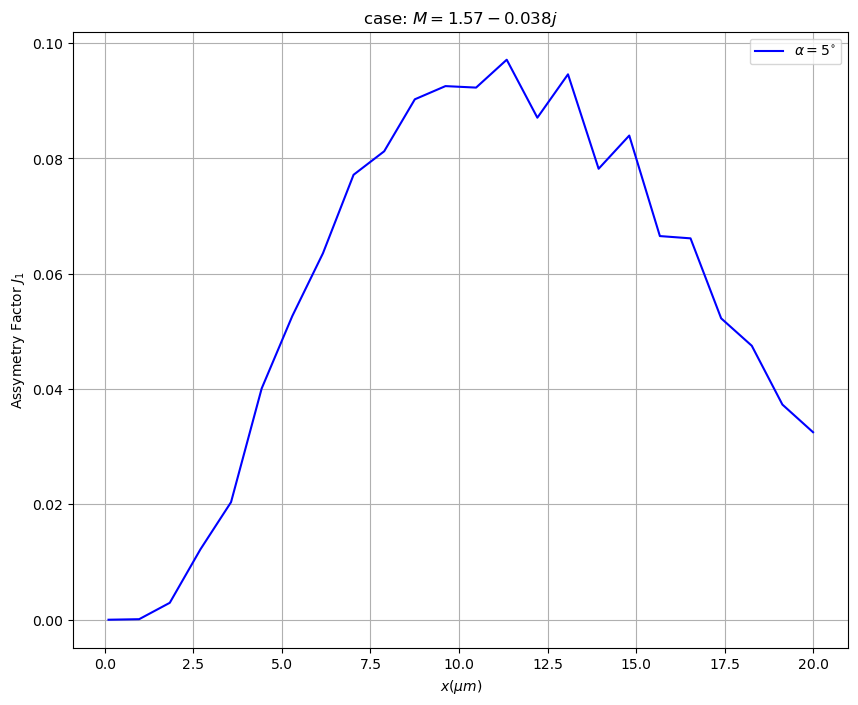

In [61]:
plt.figure(figsize=[10,8])

plt.plot(xval, jn1_gauss_blue,"b", label= r'$\alpha = 5^{\circ}$' )
#plt.plot(xval, jn2_gauss_red,"r", label= r'$\alpha = 10^{\circ}$' )
#plt.plot(xval, jn3_gauss_green,"g", label= r'$\alpha = 15^{\circ}$' )

#plt.ylim(-0.1, 0.1)

plt.xlabel(r'$x (\mu m)$')
plt.ylabel(r'Assymetry Factor $J_1$')

plt.title(r'case: $M = 1.57 - 0.038j$')
plt.legend()
plt.grid()
plt.show()

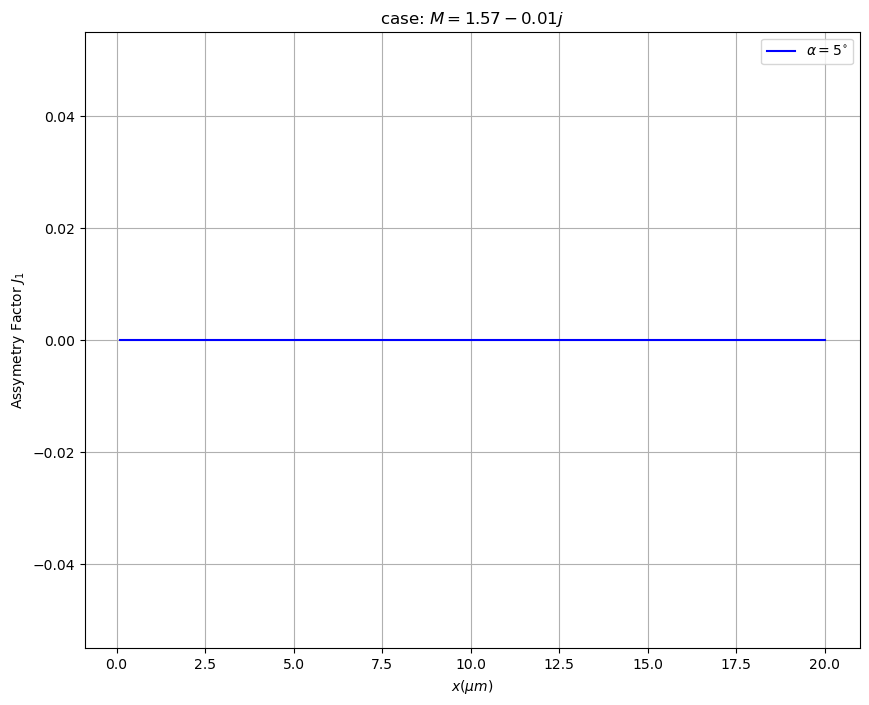

In [62]:
plt.figure(figsize=[10,8])

plt.plot(xval, n1,"b", label= r'$\alpha = 5^{\circ}$' )
#plt.plot(xval, n2,"r", label= r'$\alpha = 10^{\circ}$' )
#plt.plot(xval, n3,"g", label= r'$\alpha = 15^{\circ}$' )


plt.xlabel(r'$x (\mu m)$')
plt.ylabel(r'Assymetry Factor $J_1$')

plt.title(r'case: $M = 1.57 - 0.01j$')
plt.legend()
plt.grid()
plt.show()